In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyrsgis

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 97.1 MB/s eta 0:00:00


In [4]:
!pip install rasterio matplotlib

# Load Model VGG16

In [5]:
from tensorflow.keras.models import load_model

# Load the model from disk
model_pathname = '/content/drive/MyDrive/Skripsi/AfterSemhas/ModelRevisi/Fix9685VGG16(50)Revisi.h5'
load_vgg16_model = load_model(model_pathname)
model = load_vgg16_model

# Model is now loaded and ready to use
print("Model loaded successfully.")

Model loaded successfully.


# Taman Buru Semidang Bukit Kabupaten Seluma 2016

## Visualisasi Ground Truth dari Citra Input

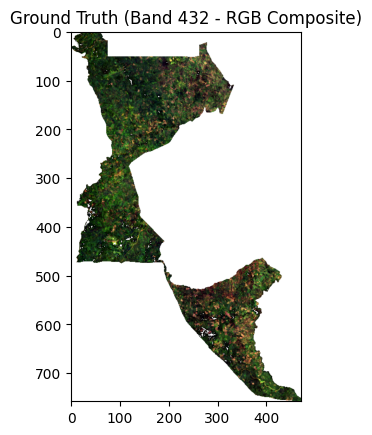

In [6]:
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np

tiff_path = "/content/drive/MyDrive/Skripsi/Raster/Normal/2016.tif"

with rasterio.open(tiff_path) as src:
    all_bands = src.read()
    nodata_value = src.nodata

    # Pilih band untuk tampilan RGB (Band 4, 3, 2 -> indeks 3, 2, 1)
    rgb_bands_for_display = all_bands[[0, 1, 2], :, :]

    display_image = reshape_as_image(rgb_bands_for_display)

    # --- PERBAIKAN: Konversi display_image ke tipe float sebelum menetapkan NaN ---
    display_image = display_image.astype(float)
    # --- END PERBAIKAN ---

    # Convert known nodata values to NaN
    if nodata_value is not None:
        # Pastikan nodata_value juga dikonversi ke float jika display_image sudah float
        display_image[display_image == float(nodata_value)] = np.nan

    # Treat very low values (like 0) as background and set to NaN
    background_mask = np.all(display_image == 0, axis=-1)
    display_image[background_mask] = np.nan

    # Normalisasi gambar
    max_val = np.nanmax(display_image)

    if max_val == 0 or np.isnan(max_val):
        max_val = 1.0

    normalized_image = display_image / max_val

    # Ganti NaN dengan 1.0 (putih setelah normalisasi)
    normalized_image[np.isnan(normalized_image)] = 1.0

    plt.title("Ground Truth (Band 432 - RGB Composite)")
    plt.imshow(normalized_image)
    plt.axis('on')
    plt.show()

## Ekstraksi Chip Citra Multispektral untuk Deep Learning

In [7]:
from pyrsgis import raster, ml # Import raster again to make sure it is accessible

# Load a new multispectral image
ds, imagas = raster.read('/content/drive/MyDrive/Skripsi/Raster/Normal/2016.tif')

# Extract chips with the correct size and channels
# Adjust y_size and x_size to 75 to match your training data
new_features = ml.array_to_chips(imagas, x_size=75, y_size=75)

# Reshape to (num_samples, height, width, channels)
num_samples = new_features.shape[0]

# Reshape to match the expected input shape of the model (None, 75, 75, 3)
# If your image has more than 3 channels, select the first 3
new_features_reshaped = new_features.reshape(num_samples, 75, 75, new_features.shape[-1])[:, :, :, :3]


## Prediksi Citra Multispektral

In [8]:
import gc  # Import the gc module
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
import rasterio

# Membersihkan sesi
clear_session()

# Opsional: Mengumpulkan sampah
gc.collect()

# Try reducing batch size for prediction
batch_size = 512  # Or try smaller batch sizes like 16, 8, etc.

# Memprediksi data baru menggunakan model yang telah dilatih
newPredicted = model.predict(new_features_reshaped, batch_size=batch_size)  # Use new_features_reshaped and added batch_size

print("Prediksi selesai.")
print(f"Shape dari hasil prediksi: {newPredicted.shape}")
print(f"Contoh hasil prediksi (probabilitas): \n{newPredicted[:5]}")

699/699 ━━━━━━━━━━━━━━━━━━━━ 123s 147ms/step
Prediksi selesai.
Shape dari hasil prediksi: (357776, 2)
Contoh hasil prediksi (probabilitas): 
[[0.64626247 0.3537375 ]
 [0.78107464 0.21892537]
 [0.6824875  0.31751254]
 [0.72452855 0.27547148]
 [0.78771544 0.21228456]]


## Visualisasi Hasil Klasifikasi Citra Multispektral

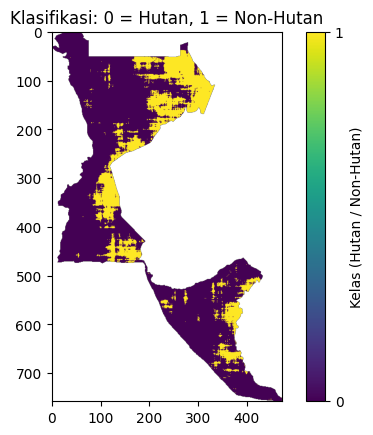

In [9]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Threshold untuk menentukan kelas
threshold = 0.991  # Sesuaikan threshold sesuai kebutuhan

# Ambil probabilitas prediksi untuk kelas "Non-Hutan"
non_forest_probabilities = newPredicted[:, 1]  # Ambil probabilitas untuk kelas "Non-Hutan"

# Gunakan threshold untuk menentukan kelas
# 0 untuk "Hutan" dan 1 untuk "Non-Hutan"
predicted_classes = (non_forest_probabilities >= threshold)

# Membaca mask dari citra raster
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2016.tif") as src:
    mask = src.dataset_mask()  # Mask biner: 255 untuk wilayah valid, 0 untuk tidak valid

# Reshape predicted_classes ke dimensi raster
predicted_classes_reshaped = np.reshape(predicted_classes, (ds.RasterYSize, ds.RasterXSize))

# Terapkan mask pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)  # Gunakan NaN untuk area non-valid

# Plot hasil prediksi dengan masking
fig, ax = plt.subplots()
h = ax.imshow(masked_prediction, vmin=0, vmax=1)
fig.colorbar(h, ticks=np.linspace(0, 1, 2), label='Kelas (Hutan / Non-Hutan)')
ax.set_title('Klasifikasi: 0 = Hutan, 1 = Non-Hutan')
plt.show()


## Perhitungan Luas Hutan dan Non-Hutan dari Citra Klasifikasi

In [10]:
import numpy as np
import rasterio

# Tetapkan resolusi piksel menjadi 30x30 meter
pixel_size_x = 30  # Resolusi dalam arah x
pixel_size_y = 30  # Resolusi dalam arah y
pixel_area = pixel_size_x * pixel_size_y  # Luas piksel dalam m²

# Hitung jumlah piksel untuk kelas hutan (0) dan non-hutan (1)
forest_pixels2016 = np.sum(masked_prediction == 0)  # Piksel dengan nilai kelas hutan
non_forest_pixels2016 = np.sum(masked_prediction == 1)  # Piksel dengan nilai kelas non-hutan

# Hitung luas total dalam m²
forest_area_m2_2016 = forest_pixels2016 * pixel_area  # Luas hutan
non_forest_area_m2_2016 = non_forest_pixels2016 * pixel_area  # Luas non-hutan

# Konversi luas ke hektar
forest_area_hectares = forest_area_m2_2016 / 10000  # 1 hektar = 10,000 m²
non_forest_area_hectares = non_forest_area_m2_2016 / 10000

# Tampilkan hasil dengan 2 angka di belakang koma
print(f"Resolusi piksel: {pixel_size_x} x {pixel_size_y} meter")
print(f"Luas tiap piksel: {pixel_area:.2f} m²")
print(f"Jumlah piksel hutan: {forest_pixels2016}")
print(f"Jumlah piksel non-hutan: {non_forest_pixels2016}")
print(f"Luas total hutan: {forest_area_m2_2016:.2f} m² ({forest_area_hectares:.2f} hektar)")
print(f"Luas total non-hutan: {non_forest_area_m2_2016:.2f} m² ({non_forest_area_hectares:.2f} hektar)")


Resolusi piksel: 30 x 30 meter
Luas tiap piksel: 900.00 m²
Jumlah piksel hutan: 79704
Jumlah piksel non-hutan: 23640
Luas total hutan: 71733600.00 m² (7173.36 hektar)
Luas total non-hutan: 21276000.00 m² (2127.60 hektar)


## Menyimpan Hasil Klasifikasi sebagai Citra Raster TIFF

In [11]:
import rasterio

# File output
output_file = r'/content/drive/MyDrive/Skripsi/AfterSemhas/FixHasilRaster(Rev)/(9685)VGG16-Klasifikasi2016.tif'

# Open the original raster to get the profile
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2016.tif") as src:
    profile = src.profile

# Update the profile for saving the result
profile.update(
    dtype='float32',  # Tipe data float32
    count=1,          # Hanya satu band
    compress='lzw',   # Kompresi untuk efisiensi penyimpanan
    nodata=np.nan     # Nilai NoData diatur sebagai NaN
)

# Terapkan masking pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)

# Simpan hasil klasifikasi ke file .tif
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(masked_prediction.astype('float32'), 1)

print(f"Hasil klasifikasi disimpan di: {output_file}")

Hasil klasifikasi disimpan di: /content/drive/MyDrive/Skripsi/AfterSemhas/FixHasilRaster(Rev)/(9685)VGG16-Klasifikasi2016.tif


# Taman Buru Semidang Bukit Kabupaten Seluma 2017

## Visualisasi Ground Truth dari Citra Input

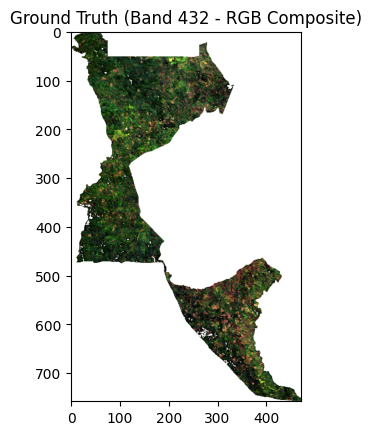

In [12]:
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np

tiff_path = "/content/drive/MyDrive/Skripsi/Raster/Normal/2017.tif"

with rasterio.open(tiff_path) as src:
    all_bands = src.read()
    nodata_value = src.nodata

    # Pilih band untuk tampilan RGB (Band 4, 3, 2 -> indeks 3, 2, 1)
    rgb_bands_for_display = all_bands[[0, 1, 2], :, :]

    display_image = reshape_as_image(rgb_bands_for_display)

    # --- PERBAIKAN: Konversi display_image ke tipe float sebelum menetapkan NaN ---
    display_image = display_image.astype(float)
    # --- END PERBAIKAN ---

    # Convert known nodata values to NaN
    if nodata_value is not None:
        # Pastikan nodata_value juga dikonversi ke float jika display_image sudah float
        display_image[display_image == float(nodata_value)] = np.nan

    # Treat very low values (like 0) as background and set to NaN
    background_mask = np.all(display_image == 0, axis=-1)
    display_image[background_mask] = np.nan

    # Normalisasi gambar
    max_val = np.nanmax(display_image)

    if max_val == 0 or np.isnan(max_val):
        max_val = 1.0

    normalized_image = display_image / max_val

    # Ganti NaN dengan 1.0 (putih setelah normalisasi)
    normalized_image[np.isnan(normalized_image)] = 1.0

    plt.title("Ground Truth (Band 432 - RGB Composite)")
    plt.imshow(normalized_image)
    plt.axis('on')
    plt.show()

## Ekstraksi Chip Citra Multispektral untuk Deep Learning

In [13]:
from pyrsgis import raster, ml # Import raster again to make sure it is accessible
model = load_vgg16_model

# Load a new multispectral image
ds, imagas = raster.read('/content/drive/MyDrive/Skripsi/Raster/Normal/2017.tif')

# Extract chips with the correct size and channels
# Adjust y_size and x_size to 75 to match your training data
new_features = ml.array_to_chips(imagas, x_size=75, y_size=75)

# Reshape to (num_samples, height, width, channels)
num_samples = new_features.shape[0]

# Reshape to match the expected input shape of the model (None, 75, 75, 3)
# If your image has more than 3 channels, select the first 3
new_features_reshaped = new_features.reshape(num_samples, 75, 75, new_features.shape[-1])[:, :, :, :3]


## Prediksi Citra Multispektral

In [14]:
import gc  # Import the gc module
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
import rasterio

# Membersihkan sesi
clear_session()

# Opsional: Mengumpulkan sampah
gc.collect()

# Try reducing batch size for prediction
batch_size = 512  # Or try smaller batch sizes like 16, 8, etc.

# Memprediksi data baru menggunakan model yang telah dilatih
newPredicted = model.predict(new_features_reshaped, batch_size=batch_size)  # Use new_features_reshaped and added batch_size

print("Prediksi selesai.")
print(f"Shape dari hasil prediksi: {newPredicted.shape}")
print(f"Contoh hasil prediksi (probabilitas): \n{newPredicted[:5]}")

699/699 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step
Prediksi selesai.
Shape dari hasil prediksi: (357776, 2)
Contoh hasil prediksi (probabilitas): 
[[0.5645345  0.4354655 ]
 [0.6608692  0.33913082]
 [0.4885554  0.5114446 ]
 [0.5228242  0.47717574]
 [0.68259484 0.31740513]]


## Visualisasi Hasil Klasifikasi Citra Multispektral

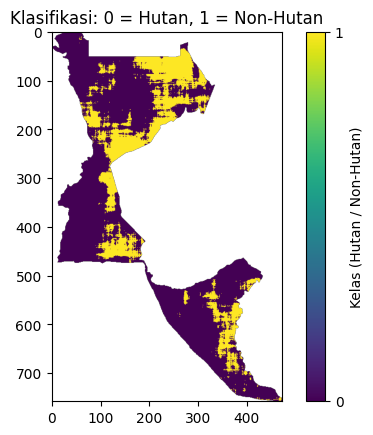

In [15]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Threshold untuk menentukan kelas
threshold = 0.994  # Sesuaikan threshold sesuai kebutuhan

# Ambil probabilitas prediksi untuk kelas "Non-Hutan"
non_forest_probabilities = newPredicted[:, 1]  # Ambil probabilitas untuk kelas "Non-Hutan"

# Gunakan threshold untuk menentukan kelas
# 0 untuk "Hutan" dan 1 untuk "Non-Hutan"
predicted_classes = (non_forest_probabilities >= threshold)

# Membaca mask dari citra raster
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2017.tif") as src:
    mask = src.dataset_mask()  # Mask biner: 255 untuk wilayah valid, 0 untuk tidak valid

# Reshape predicted_classes ke dimensi raster
predicted_classes_reshaped = np.reshape(predicted_classes, (ds.RasterYSize, ds.RasterXSize))

# Terapkan mask pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)  # Gunakan NaN untuk area non-valid

# Plot hasil prediksi dengan masking
fig, ax = plt.subplots()
h = ax.imshow(masked_prediction, vmin=0, vmax=1)
fig.colorbar(h, ticks=np.linspace(0, 1, 2), label='Kelas (Hutan / Non-Hutan)')
ax.set_title('Klasifikasi: 0 = Hutan, 1 = Non-Hutan')
plt.show()


## Perhitungan Luas Hutan dan Non-Hutan dari Citra Klasifikasi

In [16]:
import numpy as np
import rasterio

# Tetapkan resolusi piksel menjadi 30x30 meter
pixel_size_x = 30  # Resolusi dalam arah x
pixel_size_y = 30  # Resolusi dalam arah y
pixel_area = pixel_size_x * pixel_size_y  # Luas piksel dalam m²

# Hitung jumlah piksel untuk kelas hutan (0) dan non-hutan (1)
forest_pixels2017 = np.sum(masked_prediction == 0)  # Piksel dengan nilai kelas hutan
non_forest_pixels2017 = np.sum(masked_prediction == 1)  # Piksel dengan nilai kelas non-hutan

# Hitung luas total dalam m²
forest_area_m2_2017 = forest_pixels2017 * pixel_area  # Luas hutan
non_forest_area_m2_2017 = non_forest_pixels2017 * pixel_area  # Luas non-hutan

# Konversi luas ke hektar
forest_area_hectares = forest_area_m2_2017 / 10000  # 1 hektar = 10,000 m²
non_forest_area_hectares = non_forest_area_m2_2017 / 10000

# Tampilkan hasil dengan 2 angka di belakang koma
print(f"Resolusi piksel: {pixel_size_x} x {pixel_size_y} meter")
print(f"Luas tiap piksel: {pixel_area:.2f} m²")
print(f"Jumlah piksel hutan: {forest_pixels2017}")
print(f"Jumlah piksel non-hutan: {non_forest_pixels2017}")
print(f"Luas total hutan: {forest_area_m2_2017:.2f} m² ({forest_area_hectares:.2f} hektar)")
print(f"Luas total non-hutan: {non_forest_area_m2_2017:.2f} m² ({non_forest_area_hectares:.2f} hektar)")


Resolusi piksel: 30 x 30 meter
Luas tiap piksel: 900.00 m²
Jumlah piksel hutan: 76097
Jumlah piksel non-hutan: 27247
Luas total hutan: 68487300.00 m² (6848.73 hektar)
Luas total non-hutan: 24522300.00 m² (2452.23 hektar)


## Menyimpan Hasil Klasifikasi sebagai Citra Raster TIFF

In [17]:
import rasterio

# File output
output_file = r'/content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2017.tif.tif'

# Open the original raster to get the profile
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2017.tif") as src:
    profile = src.profile

# Update the profile for saving the result
profile.update(
    dtype='float32',  # Tipe data float32
    count=1,          # Hanya satu band
    compress='lzw',   # Kompresi untuk efisiensi penyimpanan
    nodata=np.nan     # Nilai NoData diatur sebagai NaN
)

# Terapkan masking pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)

# Simpan hasil klasifikasi ke file .tif
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(masked_prediction.astype('float32'), 1)

print(f"Hasil klasifikasi disimpan di: {output_file}")

Hasil klasifikasi disimpan di: /content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2017.tif.tif


# Taman Buru Semidang Bukit Kabupaten Seluma 2018

## Visualisasi Ground Truth dari Citra Input

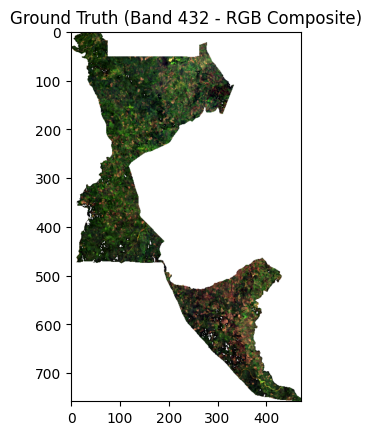

In [18]:
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np

tiff_path = "/content/drive/MyDrive/Skripsi/Raster/Normal/2018.tif"

with rasterio.open(tiff_path) as src:
    all_bands = src.read()
    nodata_value = src.nodata

    # Pilih band untuk tampilan RGB (Band 4, 3, 2 -> indeks 3, 2, 1)
    rgb_bands_for_display = all_bands[[0, 1, 2], :, :]

    display_image = reshape_as_image(rgb_bands_for_display)

    # --- PERBAIKAN: Konversi display_image ke tipe float sebelum menetapkan NaN ---
    display_image = display_image.astype(float)
    # --- END PERBAIKAN ---

    # Convert known nodata values to NaN
    if nodata_value is not None:
        # Pastikan nodata_value juga dikonversi ke float jika display_image sudah float
        display_image[display_image == float(nodata_value)] = np.nan

    # Treat very low values (like 0) as background and set to NaN
    background_mask = np.all(display_image == 0, axis=-1)
    display_image[background_mask] = np.nan

    # Normalisasi gambar
    max_val = np.nanmax(display_image)

    if max_val == 0 or np.isnan(max_val):
        max_val = 1.0

    normalized_image = display_image / max_val

    # Ganti NaN dengan 1.0 (putih setelah normalisasi)
    normalized_image[np.isnan(normalized_image)] = 1.0

    plt.title("Ground Truth (Band 432 - RGB Composite)")
    plt.imshow(normalized_image)
    plt.axis('on')
    plt.show()

## Ekstraksi Chip Citra Multispektral untuk Deep Learning

In [19]:
from pyrsgis import raster, ml # Import raster again to make sure it is accessible
model = load_vgg16_model

# Load a new multispectral image
ds, imagas = raster.read('/content/drive/MyDrive/Skripsi/Raster/Normal/2018.tif')

# Extract chips with the correct size and channels
# Adjust y_size and x_size to 75 to match your training data
new_features = ml.array_to_chips(imagas, x_size=75, y_size=75)

# Reshape to (num_samples, height, width, channels)
num_samples = new_features.shape[0]

# Reshape to match the expected input shape of the model (None, 75, 75, 3)
# If your image has more than 3 channels, select the first 3
new_features_reshaped = new_features.reshape(num_samples, 75, 75, new_features.shape[-1])[:, :, :, :3]


## Prediksi Citra Multispektral

In [20]:
import gc  # Import the gc module
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
import rasterio

# Membersihkan sesi
clear_session()

# Opsional: Mengumpulkan sampah
gc.collect()

# Try reducing batch size for prediction
batch_size = 512  # Or try smaller batch sizes like 16, 8, etc.

# Memprediksi data baru menggunakan model yang telah dilatih
newPredicted = model.predict(new_features_reshaped, batch_size=batch_size)  # Use new_features_reshaped and added batch_size

print("Prediksi selesai.")
print(f"Shape dari hasil prediksi: {newPredicted.shape}")
print(f"Contoh hasil prediksi (probabilitas): \n{newPredicted[:5]}")

699/699 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step
Prediksi selesai.
Shape dari hasil prediksi: (357776, 2)
Contoh hasil prediksi (probabilitas): 
[[0.34017062 0.65982944]
 [0.4440097  0.5559903 ]
 [0.51311886 0.48688108]
 [0.377066   0.62293404]
 [0.578388   0.42161202]]


## Visualisasi Hasil Klasifikasi Citra Multispektral

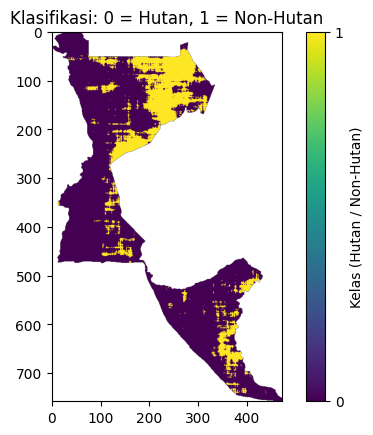

In [21]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Threshold untuk menentukan kelas
threshold = 0.991  # Sesuaikan threshold sesuai kebutuhan

# Ambil probabilitas prediksi untuk kelas "Non-Hutan"
non_forest_probabilities = newPredicted[:, 1]  # Ambil probabilitas untuk kelas "Non-Hutan"

# Gunakan threshold untuk menentukan kelas
# 0 untuk "Hutan" dan 1 untuk "Non-Hutan"
predicted_classes = (non_forest_probabilities >= threshold).astype(int)

# Membaca mask dari citra raster
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2018.tif") as src:
    mask = src.dataset_mask()  # Mask biner: 255 untuk wilayah valid, 0 untuk tidak valid

# Reshape predicted_classes ke dimensi raster
predicted_classes_reshaped = np.reshape(predicted_classes, (ds.RasterYSize, ds.RasterXSize))

# Terapkan mask pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)  # Gunakan NaN untuk area non-valid

# Plot hasil prediksi dengan masking
fig, ax = plt.subplots()
h = ax.imshow(masked_prediction, vmin=0, vmax=1)
fig.colorbar(h, ticks=np.linspace(0, 1, 2), label='Kelas (Hutan / Non-Hutan)')
ax.set_title('Klasifikasi: 0 = Hutan, 1 = Non-Hutan')
plt.show()


## Perhitungan Luas Hutan dan Non-Hutan dari Citra Klasifikasi

In [22]:
import numpy as np
import rasterio

# Tetapkan resolusi piksel menjadi 30x30 meter
pixel_size_x = 30  # Resolusi dalam arah x
pixel_size_y = 30  # Resolusi dalam arah y
pixel_area = pixel_size_x * pixel_size_y  # Luas piksel dalam m²

# Hitung jumlah piksel untuk kelas hutan (0) dan non-hutan (1)
forest_pixels2018 = np.sum(masked_prediction == 0)  # Piksel dengan nilai kelas hutan
non_forest_pixels2018 = np.sum(masked_prediction == 1)  # Piksel dengan nilai kelas non-hutan

# Hitung luas total dalam m²
forest_area_m2_2018 = forest_pixels2018 * pixel_area  # Luas hutan
non_forest_area_m2_2018 = non_forest_pixels2018 * pixel_area  # Luas non-hutan

# Konversi luas ke hektar
forest_area_hectares = forest_area_m2_2018 / 10000  # 1 hektar = 10,000 m²
non_forest_area_hectares = non_forest_area_m2_2018 / 10000

# Tampilkan hasil dengan 2 angka di belakang koma
print(f"Resolusi piksel: {pixel_size_x} x {pixel_size_y} meter")
print(f"Luas tiap piksel: {pixel_area:.2f} m²")
print(f"Jumlah piksel hutan: {forest_pixels2018}")
print(f"Jumlah piksel non-hutan: {non_forest_pixels2018}")
print(f"Luas total hutan: {forest_area_m2_2018:.2f} m² ({forest_area_hectares:.2f} hektar)")
print(f"Luas total non-hutan: {non_forest_area_m2_2018:.2f} m² ({non_forest_area_hectares:.2f} hektar)")


Resolusi piksel: 30 x 30 meter
Luas tiap piksel: 900.00 m²
Jumlah piksel hutan: 80358
Jumlah piksel non-hutan: 22986
Luas total hutan: 72322200.00 m² (7232.22 hektar)
Luas total non-hutan: 20687400.00 m² (2068.74 hektar)


## Menyimpan Hasil Klasifikasi sebagai Citra Raster TIFF

In [23]:
import rasterio

# File output
output_file = r'/content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2018.tif.tif'

# Open the original raster to get the profile
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2018.tif") as src:
    profile = src.profile

# Update the profile for saving the result
profile.update(
    dtype='float32',  # Tipe data float32
    count=1,          # Hanya satu band
    compress='lzw',   # Kompresi untuk efisiensi penyimpanan
    nodata=np.nan     # Nilai NoData diatur sebagai NaN
)

# Terapkan masking pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)

# Simpan hasil klasifikasi ke file .tif
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(masked_prediction.astype('float32'), 1)

print(f"Hasil klasifikasi disimpan di: {output_file}")

Hasil klasifikasi disimpan di: /content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2018.tif.tif


# Taman Buru Semidang Bukit Kabupaten Seluma 2019

## Visualisasi Ground Truth dari Citra Input

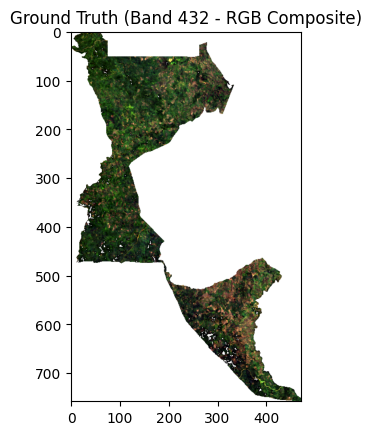

In [24]:
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np

tiff_path = "/content/drive/MyDrive/Skripsi/Raster/Normal/2019.tif"

with rasterio.open(tiff_path) as src:
    all_bands = src.read()
    nodata_value = src.nodata

    # Pilih band untuk tampilan RGB (Band 4, 3, 2 -> indeks 3, 2, 1)
    rgb_bands_for_display = all_bands[[0, 1, 2], :, :]

    display_image = reshape_as_image(rgb_bands_for_display)

    # --- PERBAIKAN: Konversi display_image ke tipe float sebelum menetapkan NaN ---
    display_image = display_image.astype(float)
    # --- END PERBAIKAN ---

    # Convert known nodata values to NaN
    if nodata_value is not None:
        # Pastikan nodata_value juga dikonversi ke float jika display_image sudah float
        display_image[display_image == float(nodata_value)] = np.nan

    # Treat very low values (like 0) as background and set to NaN
    background_mask = np.all(display_image == 0, axis=-1)
    display_image[background_mask] = np.nan

    # Normalisasi gambar
    max_val = np.nanmax(display_image)

    if max_val == 0 or np.isnan(max_val):
        max_val = 1.0

    normalized_image = display_image / max_val

    # Ganti NaN dengan 1.0 (putih setelah normalisasi)
    normalized_image[np.isnan(normalized_image)] = 1.0

    plt.title("Ground Truth (Band 432 - RGB Composite)")
    plt.imshow(normalized_image)
    plt.axis('on')
    plt.show()

## Ekstraksi Chip Citra Multispektral untuk Deep Learning

In [25]:
from pyrsgis import raster, ml # Import raster again to make sure it is accessible
model = load_vgg16_model

# Load a new multispectral image
ds, imagas = raster.read('/content/drive/MyDrive/Skripsi/Raster/Normal/2019.tif')

# Extract chips with the correct size and channels
# Adjust y_size and x_size to 75 to match your training data
new_features = ml.array_to_chips(imagas, x_size=75, y_size=75)

# Reshape to (num_samples, height, width, channels)
num_samples = new_features.shape[0]

# Reshape to match the expected input shape of the model (None, 75, 75, 3)
# If your image has more than 3 channels, select the first 3
new_features_reshaped = new_features.reshape(num_samples, 75, 75, new_features.shape[-1])[:, :, :, :3]


## Prediksi Citra Multispektral

In [26]:
import gc  # Import the gc module
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
import rasterio

# Membersihkan sesi
clear_session()

# Opsional: Mengumpulkan sampah
gc.collect()

# Try reducing batch size for prediction
batch_size = 512  # Or try smaller batch sizes like 16, 8, etc.

# Memprediksi data baru menggunakan model yang telah dilatih
newPredicted = model.predict(new_features_reshaped, batch_size=batch_size)  # Use new_features_reshaped and added batch_size

print("Prediksi selesai.")
print(f"Shape dari hasil prediksi: {newPredicted.shape}")
print(f"Contoh hasil prediksi (probabilitas): \n{newPredicted[:5]}")

699/699 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step
Prediksi selesai.
Shape dari hasil prediksi: (357776, 2)
Contoh hasil prediksi (probabilitas): 
[[0.48817542 0.5118246 ]
 [0.539042   0.46095797]
 [0.3491607  0.6508393 ]
 [0.54563457 0.4543654 ]
 [0.699451   0.30054897]]


## Visualisasi Hasil Klasifikasi Citra Multispektral

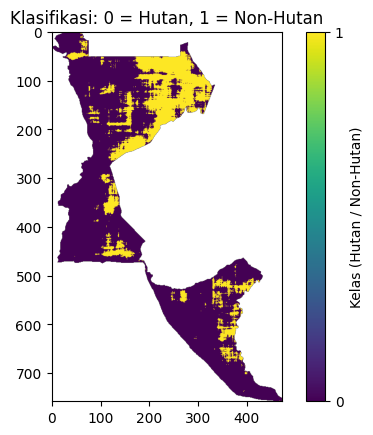

In [27]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Threshold untuk menentukan kelas
threshold = 0.991  # Sesuaikan threshold sesuai kebutuhan

# Ambil probabilitas prediksi untuk kelas "Non-Hutan"
non_forest_probabilities = newPredicted[:, 1]  # Ambil probabilitas untuk kelas "Non-Hutan"

# Gunakan threshold untuk menentukan kelas
# 0 untuk "Hutan" dan 1 untuk "Non-Hutan"
predicted_classes = (non_forest_probabilities >= threshold)

# Membaca mask dari citra raster
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2019.tif") as src:
    mask = src.dataset_mask()  # Mask biner: 255 untuk wilayah valid, 0 untuk tidak valid

# Reshape predicted_classes ke dimensi raster
predicted_classes_reshaped = np.reshape(predicted_classes, (ds.RasterYSize, ds.RasterXSize))

# Terapkan mask pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)  # Gunakan NaN untuk area non-valid

# Plot hasil prediksi dengan masking
fig, ax = plt.subplots()
h = ax.imshow(masked_prediction, vmin=0, vmax=1)
fig.colorbar(h, ticks=np.linspace(0, 1, 2), label='Kelas (Hutan / Non-Hutan)')
ax.set_title('Klasifikasi: 0 = Hutan, 1 = Non-Hutan')
plt.show()


## Perhitungan Luas Hutan dan Non-Hutan dari Citra Klasifikasi

In [28]:
import numpy as np
import rasterio

# Tetapkan resolusi piksel menjadi 30x30 meter
pixel_size_x = 30  # Resolusi dalam arah x
pixel_size_y = 30  # Resolusi dalam arah y
pixel_area = pixel_size_x * pixel_size_y  # Luas piksel dalam m²

# Hitung jumlah piksel untuk kelas hutan (0) dan non-hutan (1)
forest_pixels2019 = np.sum(masked_prediction == 0)  # Piksel dengan nilai kelas hutan
non_forest_pixels2019 = np.sum(masked_prediction == 1)  # Piksel dengan nilai kelas non-hutan

# Hitung luas total dalam m²
forest_area_m2_2019 = forest_pixels2019 * pixel_area  # Luas hutan
non_forest_area_m2_2019 = non_forest_pixels2019 * pixel_area  # Luas non-hutan

# Konversi luas ke hektar
forest_area_hectares = forest_area_m2_2019 / 10000  # 1 hektar = 10,000 m²
non_forest_area_hectares = non_forest_area_m2_2019 / 10000

# Tampilkan hasil dengan 2 angka di belakang koma
print(f"Resolusi piksel: {pixel_size_x} x {pixel_size_y} meter")
print(f"Luas tiap piksel: {pixel_area:.2f} m²")
print(f"Jumlah piksel hutan: {forest_pixels2019}")
print(f"Jumlah piksel non-hutan: {non_forest_pixels2019}")
print(f"Luas total hutan: {forest_area_m2_2019:.2f} m² ({forest_area_hectares:.2f} hektar)")
print(f"Luas total non-hutan: {non_forest_area_m2_2019:.2f} m² ({non_forest_area_hectares:.2f} hektar)")


Resolusi piksel: 30 x 30 meter
Luas tiap piksel: 900.00 m²
Jumlah piksel hutan: 78695
Jumlah piksel non-hutan: 24649
Luas total hutan: 70825500.00 m² (7082.55 hektar)
Luas total non-hutan: 22184100.00 m² (2218.41 hektar)


## Menyimpan Hasil Klasifikasi sebagai Citra Raster TIFF

In [29]:
import rasterio

# File output
output_file = r'/content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2019.tif'

# Open the original raster to get the profile
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2019.tif") as src:
    profile = src.profile

# Update the profile for saving the result
profile.update(
    dtype='float32',  # Tipe data float32
    count=1,          # Hanya satu band
    compress='lzw',   # Kompresi untuk efisiensi penyimpanan
    nodata=np.nan     # Nilai NoData diatur sebagai NaN
)

# Terapkan masking pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)

# Simpan hasil klasifikasi ke file .tif
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(masked_prediction.astype('float32'), 1)

print(f"Hasil klasifikasi disimpan di: {output_file}")

Hasil klasifikasi disimpan di: /content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2019.tif


# Taman Buru Semidang Bukit Kabupaten Seluma 2020

## Visualisasi Ground Truth dari Citra Input

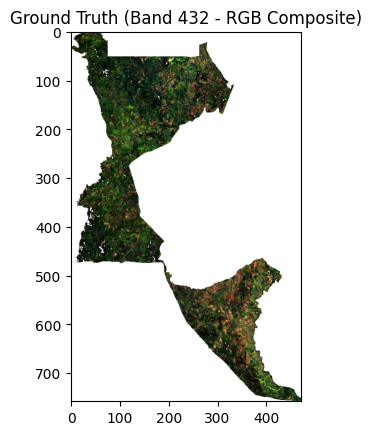

In [30]:
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np

tiff_path = "/content/drive/MyDrive/Skripsi/Raster/Normal/2020.tif"

with rasterio.open(tiff_path) as src:
    all_bands = src.read()
    nodata_value = src.nodata

    # Pilih band untuk tampilan RGB (Band 4, 3, 2 -> indeks 3, 2, 1)
    rgb_bands_for_display = all_bands[[0, 1, 2], :, :]

    display_image = reshape_as_image(rgb_bands_for_display)

    # --- PERBAIKAN: Konversi display_image ke tipe float sebelum menetapkan NaN ---
    display_image = display_image.astype(float)
    # --- END PERBAIKAN ---

    # Convert known nodata values to NaN
    if nodata_value is not None:
        # Pastikan nodata_value juga dikonversi ke float jika display_image sudah float
        display_image[display_image == float(nodata_value)] = np.nan

    # Treat very low values (like 0) as background and set to NaN
    background_mask = np.all(display_image == 0, axis=-1)
    display_image[background_mask] = np.nan

    # Normalisasi gambar
    max_val = np.nanmax(display_image)

    if max_val == 0 or np.isnan(max_val):
        max_val = 1.0

    normalized_image = display_image / max_val

    # Ganti NaN dengan 1.0 (putih setelah normalisasi)
    normalized_image[np.isnan(normalized_image)] = 1.0

    plt.title("Ground Truth (Band 432 - RGB Composite)")
    plt.imshow(normalized_image)
    plt.axis('on')
    plt.show()

## Ekstraksi Chip Citra Multispektral untuk Deep Learning

In [31]:
from pyrsgis import raster, ml # Import raster again to make sure it is accessible
model = load_vgg16_model

# Load a new multispectral image
ds, imagas = raster.read('/content/drive/MyDrive/Skripsi/Raster/Normal/2020.tif')

# Extract chips with the correct size and channels
# Adjust y_size and x_size to 75 to match your training data
new_features = ml.array_to_chips(imagas, x_size=75, y_size=75)

# Reshape to (num_samples, height, width, channels)
num_samples = new_features.shape[0]

# Reshape to match the expected input shape of the model (None, 75, 75, 3)
# If your image has more than 3 channels, select the first 3
new_features_reshaped = new_features.reshape(num_samples, 75, 75, new_features.shape[-1])[:, :, :, :3]


## Prediksi Citra Multispektral

In [32]:
import gc  # Import the gc module
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
import rasterio

# Membersihkan sesi
clear_session()

# Opsional: Mengumpulkan sampah
gc.collect()

# Try reducing batch size for prediction
batch_size = 512  # Or try smaller batch sizes like 16, 8, etc.

# Memprediksi data baru menggunakan model yang telah dilatih
newPredicted = model.predict(new_features_reshaped, batch_size=batch_size)  # Use new_features_reshaped and added batch_size

print("Prediksi selesai.")
print(f"Shape dari hasil prediksi: {newPredicted.shape}")
print(f"Contoh hasil prediksi (probabilitas): \n{newPredicted[:5]}")

699/699 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step
Prediksi selesai.
Shape dari hasil prediksi: (357776, 2)
Contoh hasil prediksi (probabilitas): 
[[0.56143177 0.43856823]
 [0.4477762  0.5522238 ]
 [0.34007066 0.65992934]
 [0.4275187  0.5724813 ]
 [0.5384577  0.4615423 ]]


## Visualisasi Hasil Klasifikasi Citra Multispektral

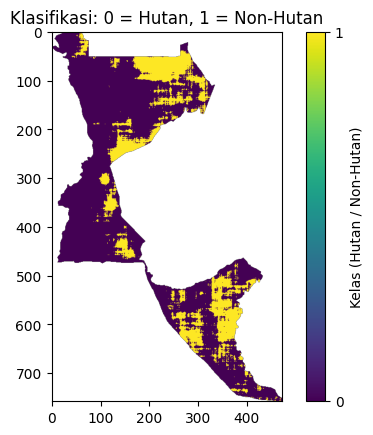

In [33]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Threshold untuk menentukan kelas
threshold = 0.99  # Sesuaikan threshold sesuai kebutuhan

# Ambil probabilitas prediksi untuk kelas "Non-Hutan"
non_forest_probabilities = newPredicted[:, 1]  # Ambil probabilitas untuk kelas "Non-Hutan"

# Gunakan threshold untuk menentukan kelas
# 0 untuk "Hutan" dan 1 untuk "Non-Hutan"
predicted_classes = (non_forest_probabilities >= threshold)

# Membaca mask dari citra raster
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2020.tif") as src:
    mask = src.dataset_mask()  # Mask biner: 255 untuk wilayah valid, 0 untuk tidak valid

# Reshape predicted_classes ke dimensi raster
predicted_classes_reshaped = np.reshape(predicted_classes, (ds.RasterYSize, ds.RasterXSize))

# Terapkan mask pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)  # Gunakan NaN untuk area non-valid

# Plot hasil prediksi dengan masking
fig, ax = plt.subplots()
h = ax.imshow(masked_prediction, vmin=0, vmax=1)
fig.colorbar(h, ticks=np.linspace(0, 1, 2), label='Kelas (Hutan / Non-Hutan)')
ax.set_title('Klasifikasi: 0 = Hutan, 1 = Non-Hutan')
plt.show()


## Perhitungan Luas Hutan dan Non-Hutan dari Citra Klasifikasi

In [34]:
import numpy as np
import rasterio

# Tetapkan resolusi piksel menjadi 30x30 meter
pixel_size_x = 30  # Resolusi dalam arah x
pixel_size_y = 30  # Resolusi dalam arah y
pixel_area = pixel_size_x * pixel_size_y  # Luas piksel dalam m²

# Hitung jumlah piksel untuk kelas hutan (0) dan non-hutan (1)
forest_pixels2020 = np.sum(masked_prediction == 0)  # Piksel dengan nilai kelas hutan
non_forest_pixels2020 = np.sum(masked_prediction == 1)  # Piksel dengan nilai kelas non-hutan

# Hitung luas total dalam m²
forest_area_m2_2020 = forest_pixels2020 * pixel_area  # Luas hutan
non_forest_area_m2_2020 = non_forest_pixels2020 * pixel_area  # Luas non-hutan

# Konversi luas ke hektar
forest_area_hectares = forest_area_m2_2020 / 10000  # 1 hektar = 10,000 m²
non_forest_area_hectares = non_forest_area_m2_2020 / 10000

# Tampilkan hasil dengan 2 angka di belakang koma
print(f"Resolusi piksel: {pixel_size_x} x {pixel_size_y} meter")
print(f"Luas tiap piksel: {pixel_area:.2f} m²")
print(f"Jumlah piksel hutan: {forest_pixels2020}")
print(f"Jumlah piksel non-hutan: {non_forest_pixels2020}")
print(f"Luas total hutan: {forest_area_m2_2020:.2f} m² ({forest_area_hectares:.2f} hektar)")
print(f"Luas total non-hutan: {non_forest_area_m2_2020:.2f} m² ({non_forest_area_hectares:.2f} hektar)")


Resolusi piksel: 30 x 30 meter
Luas tiap piksel: 900.00 m²
Jumlah piksel hutan: 78672
Jumlah piksel non-hutan: 24672
Luas total hutan: 70804800.00 m² (7080.48 hektar)
Luas total non-hutan: 22204800.00 m² (2220.48 hektar)


## Menyimpan Hasil Klasifikasi sebagai Citra Raster TIFF

In [35]:
import rasterio

# File output
output_file = r'/content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2020.tif'

# Open the original raster to get the profile
with rasterio.open("/content/drive/MyDrive/Skripsi/Raster/Normal/2020.tif") as src:
    profile = src.profile

# Update the profile for saving the result
profile.update(
    dtype='float32',  # Tipe data float32
    count=1,          # Hanya satu band
    compress='lzw',   # Kompresi untuk efisiensi penyimpanan
    nodata=np.nan     # Nilai NoData diatur sebagai NaN
)

# Terapkan masking pada hasil prediksi
masked_prediction = np.where(mask > 0, predicted_classes_reshaped, np.nan)

# Simpan hasil klasifikasi ke file .tif
with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write(masked_prediction.astype('float32'), 1)

print(f"Hasil klasifikasi disimpan di: {output_file}")

Hasil klasifikasi disimpan di: /content/drive/MyDrive/Skripsi/FixHasilRaster/(9685)VGG16-Klasifikasi2020.tif
